In [2]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')
print("CUDA:", USE_CUDA, DEVICE)

from tensorboardX import SummaryWriter

sw = SummaryWriter(logdir='.', flush_secs=5)

# import math
# from typing import Optional, List, Union
# from torch_geometric.data import Data
# from torch_geometric.typing import OptTensor
# from torch_geometric.nn.conv import MessagePassing
# from torch_geometric.transforms import LaplacianLambdaMax
# from torch_geometric.utils import remove_self_loops, add_self_loops, get_laplacian
# from torch_geometric.utils import to_dense_adj

CUDA: True cuda:0


In [3]:
'''
加载图信号数据，并将其转换为 PyTorch 的 DataLoader
流程：
1.转换数据类型：将 NumPy 数组转换为 PyTorch 张量，并确保它们的数据类型为浮点数。
2.移动到设备：将张量移动到指定的设备（如 GPU）。
3.创建数据集：使用 TensorDataset 将输入张量和目标张量配对，创建一个数据集对象。
4.创建数据加载器：使用 DataLoader 将数据集分成小批量，并设置是否打乱数据。
'''


def load_graphdata_channel1(graph_signal_matrix_filename, num_of_hours, batch_size,
                            shuffle=True, DEVICE=torch.device('cuda:0')):
    """
    :param graph_signal_matrix_filename: str
    :param num_of_hours: int
    :param num_of_days: int
    :param num_of_weeks: int
    :param DEVICE:
    :param batch_size: int
    shuffle：是否在训练数据加载器中打乱数据。

    :return:
    three DataLoaders, each dataloader contains:
    test_x_tensor: (B, N_nodes, in_feature, T_input)
    test_decoder_input_tensor: (B, N_nodes, T_output)
    test_target_tensor: (B, N_nodes, T_output)
    """

    print('load file:', graph_signal_matrix_filename)
    file_data = np.load(graph_signal_matrix_filename, allow_pickle=True)
    data = file_data['data'].item()

    '''
    torch.from_numpy 将 NumPy 数组转换为 PyTorch 张量。
    .type(torch.FloatTensor) 将张量的数据类型转换为 FloatTensor，即 32 位浮点数
    .to(DEVICE) 将张量移动到指定的设备（如 GPU 或 CPU）
    torch.utils.data.TensorDataset 创建一个数据集对象，该对象将输入张量和目标张量配对,返回一个TensorDataset对象
    TensorDataset 是PyTorch中的数据集类，用于将多个张量组合成一个数据集。每个样本由输入张量和目标张量组成。
    torch.utils.data.DataLoader 创建一个数据加载器，用于批量加载数据
    DataLoader 是PyTorch中的一个类，用于将数据集分成小批量，并在训练过程中方便地迭代数据。
    '''

    # ------- train_loader -------
    # 将 NumPy 数组转换为 PyTorch 的 Tensor 并移动到指定设备
    train_signal_0_tensor = torch.from_numpy(data['train']['signal_0']).type(torch.FloatTensor).to(DEVICE)
    train_signal_1_tensor = torch.from_numpy(data['train']['signal_1']).type(torch.FloatTensor).to(DEVICE)
    train_signal_2_tensor = torch.from_numpy(data['train']['signal_2']).type(torch.FloatTensor).to(DEVICE)
    train_target_tensor = torch.from_numpy(data['train']['target']).type(torch.FloatTensor).to(DEVICE)
    # 创建一个 TensorDataset
    train_dataset = torch.utils.data.TensorDataset(train_signal_0_tensor, train_signal_1_tensor, train_signal_2_tensor,
                                                   train_target_tensor)
    # 创建 DataLoader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    # ------- val_loader -------
    val_signal_0_tensor = torch.from_numpy(data['val']['signal_0']).type(torch.FloatTensor).to(DEVICE)
    val_signal_1_tensor = torch.from_numpy(data['val']['signal_1']).type(torch.FloatTensor).to(DEVICE)
    val_signal_2_tensor = torch.from_numpy(data['val']['signal_2']).type(torch.FloatTensor).to(DEVICE)
    val_target_tensor = torch.from_numpy(data['val']['target']).type(torch.FloatTensor).to(DEVICE)

    val_dataset = torch.utils.data.TensorDataset(val_signal_0_tensor, val_signal_1_tensor, val_signal_2_tensor,
                                                 val_target_tensor)

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)

    # ------- test_loader -------
    test_signal_0_tensor = torch.from_numpy(data['test']['signal_0']).type(torch.FloatTensor).to(DEVICE)
    test_signal_1_tensor = torch.from_numpy(data['test']['signal_1']).type(torch.FloatTensor).to(DEVICE)
    test_signal_2_tensor = torch.from_numpy(data['test']['signal_2']).type(torch.FloatTensor).to(DEVICE)
    test_target_tensor = torch.from_numpy(data['test']['target']).type(torch.FloatTensor).to(DEVICE)

    test_dataset = torch.utils.data.TensorDataset(test_signal_0_tensor, test_signal_1_tensor, test_signal_2_tensor,
                                                  test_target_tensor)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    # mean std
    stats_data = {}
    for type_ in ['signal_0', 'signal_1', 'signal_2']:
        stats = data['stats'][type_]
        stats_data[type_ + '_mean'] = stats['_mean']
        stats_data[type_ + '_std'] = stats['_std']

    # print 打印数据尺寸
    print('train:', train_signal_0_tensor.size(), train_target_tensor.size())
    print('val:', val_signal_0_tensor.size(), val_target_tensor.size())
    print('test:', test_signal_0_tensor.size(), test_target_tensor.size())
    print('stats_data:', stats_data)

    return train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, stats_data

In [4]:
graph_signal_matrix_filename = './data/38/38_quarter_single_16_18_20_dataset_astcgn.npz'
batch_size = 32
num_of_hours = 1

train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, stats_data = load_graphdata_channel1(
    graph_signal_matrix_filename, num_of_hours, batch_size)

load file: ./data/38/38_quarter_single_16_18_20_dataset_astcgn.npz
train: torch.Size([297, 38, 2, 5]) torch.Size([297, 38, 1])
val: torch.Size([99, 38, 2, 5]) torch.Size([99, 38, 1])
test: torch.Size([99, 38, 2, 5]) torch.Size([99, 38, 1])
stats_data: {'signal_0_mean': array([[[[29.81448662],
         [16.        ]]]]), 'signal_0_std': array([[[[7.38926896],
         [0.        ]]]]), 'signal_1_mean': array([[[[30.01646199],
         [18.        ]]]]), 'signal_1_std': array([[[[7.41955276],
         [0.        ]]]]), 'signal_2_mean': array([[[[30.21835141],
         [20.        ]]]]), 'signal_2_std': array([[[[7.45859301],
         [0.        ]]]])}


In [5]:
def get_adjacency_matrix(distance_df_filename, num_of_vertices, id_filename=None):
    """
    Parameters
    :param distance_df_filename:  str, path of the csv file contains edges information
    :param num_of_vertices:  int, the number of vertices
    :param id_filename:
    ----------
    Returns
    """
    if 'npy' in distance_df_filename:
        adj_mx = np.load(distance_df_filename)
        return adj_mx, None
    else:
        import csv
        A = np.zeros((int(num_of_vertices), int(num_of_vertices)), dtype=np.float32)
        distaneA = np.zeros((int(num_of_vertices), int(num_of_vertices)), dtype=np.float32)
        if id_filename:
            with open(id_filename, 'r') as f:
                id_dict = {int(i): idx for idx, i in enumerate(f.read().strip().split('\n'))}  # 把节点id（idx）映射成从0开始的索引

            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[id_dict[i], id_dict[j]] = 1
                    distaneA[id_dict[i], id_dict[j]] = distance
            return A, distaneA

        else:
            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[i, j] = 1
                    distaneA[i, j] = distance
            return A, distaneA

In [6]:
id_filename = './data/38/38_id_filename.csv'
# 邻接矩阵文件的路径，即存储交通网络连接信息的文件。
adj_filename = './data/38/38_node_distance.csv'
# num_of_vertices：节点的数量，即传感器的数量
num_of_vertices = 38  #62为混凝土内温度节点数量
# get_adjacency_matrix：用于读取邻接矩阵文件并生成邻接矩阵adj_mx和距离矩阵distance_mx。邻接矩阵adj_mx是一个66x66的矩阵，表示节点之间的连接关系。
adj_mx, distance_mx = get_adjacency_matrix(adj_filename, num_of_vertices, id_filename)

### 使用 networkx 库创建图并绘制出来。

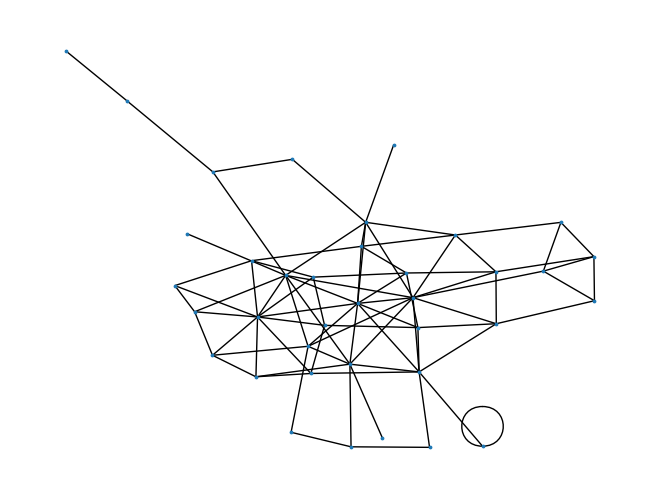

In [12]:
# 使用 networkx 库创建图并绘制出来。
# 找到邻接矩阵中值为1的位置，这些位置表示节点之间的连接。
rows, cols = np.where(adj_mx == 1)
# 将行和列索引组合成边的列表。
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=3)
plt.show()

In [13]:
# 创建PyTorch张量表示边的索引
rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())  # 将行和列索引组合成边的列表。
# torch.LongTensor(np.array([rows, cols]))：将边的行和列索引转换为PyTorch的长整型张量。
edge_index_data = torch.LongTensor(np.array([rows, cols])).to(DEVICE)

In [14]:
from torch_geometric_temporal.nn.attention import ASTGCN

In [9]:
nb_block = 2
in_channels = 1
K = 3
nb_chev_filter = 64
nb_time_filter = 64
# time_strides = num_of_hours
time_strides = 1
num_for_predict = 3
len_input = 15
#L_tilde = scaled_Laplacian(adj_mx)
#cheb_polynomials = [torch.from_numpy(i).type(torch.FloatTensor).to(DEVICE) for i in cheb_polynomial(L_tilde, K)]

# signal_0
net_0 = ASTGCN(nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input,
             num_of_vertices).to(DEVICE)
# signal_1
net_1 = ASTGCN(nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input,
               num_of_vertices).to(DEVICE)
# signal_2
net_2 = ASTGCN(nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input,
               num_of_vertices).to(DEVICE)
'''
params:
    nb_block – Number of ASTGCN blocks in the model.
    in_channels – Number of input features.
    K – Order of Chebyshev polynomials. Degree is K-1.
    time_strides – Time strides during temporal convolution.
    num_for_predict – Number of predictions to make in the future.
    len_input – Length of the input sequence.
    num_of_vertices – Number of vertices in the graph.
    normalization – The normalization scheme for the graph
'''
print(net_0)

ASTGCN(
  (_blocklist): ModuleList(
    (0): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(1, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (1): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(64, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (_final_conv): Conv2d(15, 3, kernel_size=(1, 64), stride

In [10]:
# 打印模型的所有参数及其名称
for name, param in net_0.named_parameters():
    print(f"Layer: {name} | Shape: {param.shape} | Requires Grad: {param.requires_grad}")

Layer: _blocklist.0._temporal_attention._U1 | Shape: torch.Size([62]) | Requires Grad: True
Layer: _blocklist.0._temporal_attention._U2 | Shape: torch.Size([1, 62]) | Requires Grad: True
Layer: _blocklist.0._temporal_attention._U3 | Shape: torch.Size([1]) | Requires Grad: True
Layer: _blocklist.0._temporal_attention._be | Shape: torch.Size([1, 15, 15]) | Requires Grad: True
Layer: _blocklist.0._temporal_attention._Ve | Shape: torch.Size([15, 15]) | Requires Grad: True
Layer: _blocklist.0._spatial_attention._W1 | Shape: torch.Size([15]) | Requires Grad: True
Layer: _blocklist.0._spatial_attention._W2 | Shape: torch.Size([1, 15]) | Requires Grad: True
Layer: _blocklist.0._spatial_attention._W3 | Shape: torch.Size([1]) | Requires Grad: True
Layer: _blocklist.0._spatial_attention._bs | Shape: torch.Size([1, 62, 62]) | Requires Grad: True
Layer: _blocklist.0._spatial_attention._Vs | Shape: torch.Size([62, 62]) | Requires Grad: True
Layer: _blocklist.0._chebconv_attention._weight | Shape: to

In [11]:
learning_rate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

print('Net\'s state_dict:')
total_param = 0
'''
state_dict() 方法返回一个字典，其中包含模型的所有参数和缓冲区
param_tensor 是参数的名称。
param_size 是参数张量的大小。
param_device 是参数张量所在的设备。
np.prod(param_size) 计算参数张量中所有元素的乘积，即参数的总数。
'''
for param_tensor in net.state_dict():
    print(param_tensor, '\t', net.state_dict()[param_tensor].size(), '\t', net.state_dict()[param_tensor].device)
    total_param += np.prod(net.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
_blocklist.0._temporal_attention._U1 	 torch.Size([62]) 	 cuda:0
_blocklist.0._temporal_attention._U2 	 torch.Size([1, 62]) 	 cuda:0
_blocklist.0._temporal_attention._U3 	 torch.Size([1]) 	 cuda:0
_blocklist.0._temporal_attention._be 	 torch.Size([1, 15, 15]) 	 cuda:0
_blocklist.0._temporal_attention._Ve 	 torch.Size([15, 15]) 	 cuda:0
_blocklist.0._spatial_attention._W1 	 torch.Size([15]) 	 cuda:0
_blocklist.0._spatial_attention._W2 	 torch.Size([1, 15]) 	 cuda:0
_blocklist.0._spatial_attention._W3 	 torch.Size([1]) 	 cuda:0
_blocklist.0._spatial_attention._bs 	 torch.Size([1, 62, 62]) 	 cuda:0
_blocklist.0._spatial_attention._Vs 	 torch.Size([62, 62]) 	 cuda:0
_blocklist.0._chebconv_attention._weight 	 torch.Size([3, 1, 64]) 	 cuda:0
_blocklist.0._chebconv_attention._bias 	 torch.Size([64]) 	 cuda:0
_blocklist.0._time_convolution.weight 	 torch.Size([64, 64, 1, 3]) 	 cuda:0
_blocklist.0._time_convolution.bias 	 torch.Size([64]) 	 cuda:0
_blocklist.0._residual_convol

In [12]:
def masked_mae(preds, labels, null_val=np.nan):
    '''
    :param: preds（预测值）
            labels（真实标签）
            null_val（表示无效值的标记，默认是 NaN）
    '''
    if np.isnan(null_val):
        # 生成一个掩码 mask，掩码中的每个元素表示 labels 中对应位置是否不是 NaN（即 True 表示不是 NaN，False 表示是 NaN）
        # ~ 按位取反运算符
        mask = ~torch.isnan(labels)
    else:
        # 生成一个掩码 mask，掩码中的每个元素表示 labels 中对应位置是否不等于 null_val
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean((mask))

    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    # 计算绝对误差: 计算预测值 preds 和真实标签 labels 之间的绝对误差

    # print('preds.shape:', preds.shape)
    # print('labels.shape:', labels.shape)

    loss = torch.abs(preds - labels)
    # 应用掩码: 将绝对误差与掩码相乘，这样掩码为 0 的位置（即无效值位置）的误差将被忽略（置为 0）
    loss = loss * mask
    # 处理误差中的 NaN 值: 将误差中的 NaN 值替换为 0。这是为了防止后续计算中出现 NaN 值
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    # 返回带掩码的 MAE: 计算并返回误差的均值，即带掩码的平均绝对误差
    return torch.mean(loss)

### RMSE（均方根误差）和 MAE（平均绝对误差）是两种常用的评估回归模型性能的指标。它们分别衡量预测值与实际值之间的差异，具有不同的特性和适用场景。
---
#### RMSE（Root Mean Squared Error）

RMSE 是预测值与实际值之间的均方根误差，计算公式为：

![image-20241107102637266](https://hexo-ufoozhenghao.oss-cn-beijing.aliyuncs.com/BlogHexo/image-20241107102637266.png)

其中：

- n*n* 是样本数量。
- yi*y**i* 是第 i*i* 个样本的实际值。
- y^i*y*^*i* 是第 i*i* 个样本的预测值。

##### 特点

- **敏感度**：对大的误差特别敏感，因为平方项会放大大的误差。
- **单位**：与原始数据的单位相同。

##### 适用场景

- 当需要对大的误差进行特别关注时使用。
- 更适合在误差呈正态分布时使用。

#### MAE（Mean Absolute Error）

MAE 是预测值与实际值之间的平均绝对误差，计算公式为：

![image-20241107102501396](https://hexo-ufoozhenghao.oss-cn-beijing.aliyuncs.com/BlogHexo/image-20241107102501396.png)

其中：

- n*n* 是样本数量。
- yi*y**i* 是第 i*i* 个样本的实际值。
- y^i*y*^*i* 是第 i*i* 个样本的预测值。

##### 特点

- **敏感度**：对大的误差不如 RMSE 敏感，因为绝对值不会放大大的误差。
- **单位**：与原始数据的单位相同。

##### 适用场景

- 当需要对所有误差进行均等关注时使用。
- 更适合在误差分布较均匀时使用。

#### 比较

1. **对异常值的敏感度**：
   - RMSE 对异常值更加敏感，因为平方项会放大大的误差。
   - MAE 对异常值不如 RMSE 敏感，因为绝对值不会放大大的误差。
2. **解释性**：
   - RMSE 更容易解释，因为它与原始数据的单位相同，并且对大的误差更敏感。
   - MAE 也容易解释，但它对所有误差的权重相同。
3. **选择标准**：
   - 如果希望对大的误差进行更多的惩罚，使用 RMSE。
   - 如果希望对所有误差进行均等的权重，使用 MAE。

### 使用掩码：适用于处理缺失数据或无效数据的场景，通过忽略无效数据点，提高模型的鲁棒性和灵活性。
### 不使用掩码：适用于数据集完整且无缺失值的场景，损失函数直接应用于所有数据点。

In [13]:
masked_flag = 0
criterion = nn.L1Loss().to(DEVICE)  # 初始化为 L1 损失函数（MAE，平均绝对误差）。
criterion_masked = masked_mae
loss_function = 'mse'

metric_method = 'unmask'
missing_value = 0.0

if loss_function == 'masked_mse':
    criterion_masked = masked_mse  #nn.MSELoss().to(DEVICE)
    masked_flag = 1
elif loss_function == 'masked_mae':
    criterion_masked = masked_mae
    masked_flag = 1
elif loss_function == 'mae':
    criterion = nn.L1Loss().to(DEVICE)  # MAE 损失函数
    masked_flag = 0
elif loss_function == 'rmse':
    criterion = nn.MSELoss().to(DEVICE)  # MSE 损失函数
    masked_flag = 0

In [14]:
def compute_val_loss_mstgcn(net, val_loader, criterion, masked_flag, missing_value, sw, epoch, edge_index_data,
                            limit=None):
    '''
    for rnn, compute mean loss on validation set
    :param net: model
    :param val_loader: torch.utils.data.utils.DataLoader
    :param criterion: torch.nn.MSELoss
    :param sw: tensorboardX.SummaryWriter
    :param global_step: int, current global_step
    :param limit: int,
    :return: val_loss
    '''
    # 将模型设置为评估模式 net.eval()
    net.train(False)  # ensure dropout layers are in evaluation mode
    with torch.no_grad():
        val_loader_length = len(val_loader)  # nb of batch
        tmp = []  # batch loss
        for batch_index, batch_data in enumerate(val_loader):
            encoder_inputs, labels = batch_data
            outputs = net(encoder_inputs, edge_index_data)
            # 根据 masked_flag 来选择合适的损失函数。如果 masked_flag 为真，则使用带掩码的损失函数，否则使用标准损失函数。
            if masked_flag:
                loss = criterion(outputs, labels, missing_value)
            else:
                loss = criterion(outputs, labels)
            tmp.append(loss.item())
            if batch_index % 100 == 0:
                print('validation batch %s / %s, loss: %.2f' % (batch_index + 1, val_loader_length, loss.item()))
            if (limit is not None) and batch_index >= limit:
                break

        validation_loss = sum(tmp) / len(tmp)
        sw.add_scalar('validation_loss', validation_loss, epoch)
    return validation_loss

In [15]:
global_step = 0
best_epoch = 0
# np.inf 表示正无穷大
best_val_loss = np.inf
start_time = time()

astgcn.py:
/home/nevo/miniconda3/envs/pyg-ubuntu/lib/python3.10/site-packages/torch_geometric_temporal/nn/attention/astgcn.py

In [16]:
# train model
for epoch in range(200):
    params_filename = os.path.join('./data/62/train_params/', 'epoch_%s.params' % epoch)
    masked_flag = 1
    if masked_flag:
        val_loss = compute_val_loss_mstgcn(net, val_loader, criterion_masked, masked_flag, missing_value, sw, epoch,
                                           edge_index_data)
    else:
        val_loss = compute_val_loss_mstgcn(net, val_loader, criterion, masked_flag, missing_value, sw, epoch,
                                           edge_index_data)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(net.state_dict(), params_filename)
        print('save parameters to file: %s' % params_filename)

    # 训练模式
    net.train()  # ensure dropout layers are in train mode

    for batch_index, batch_data in enumerate(train_loader):
        encoder_inputs, labels = batch_data  # encoder_inputs torch.Size([32, 307, 1, 12])  label torch.Size([32, 307, 12])
        # 清除上一步的梯度。
        optimizer.zero_grad()
        # 前向传播计算模型输出
        outputs = net(encoder_inputs, edge_index_data)  # torch.Size([32, 307, 12])

        if masked_flag:
            loss = criterion_masked(outputs, labels, missing_value)
        else:
            loss = criterion(outputs, labels)

        # 反向传播计算梯度
        loss.backward()
        #  更新模型参数
        optimizer.step()
        training_loss = loss.item()
        global_step += 1
        sw.add_scalar('training_loss', training_loss, global_step)

        if global_step % 200 == 0:
            print(
                'global step: %s, training loss: %.2f, time: %.2fs' % (global_step, training_loss, time() - start_time))

validation batch 1 / 1, loss: 22.86
save parameters to file: ./data/62/train_params/epoch_0.params
validation batch 1 / 1, loss: 22.77
save parameters to file: ./data/62/train_params/epoch_1.params
validation batch 1 / 1, loss: 22.69
save parameters to file: ./data/62/train_params/epoch_2.params
validation batch 1 / 1, loss: 22.60
save parameters to file: ./data/62/train_params/epoch_3.params
validation batch 1 / 1, loss: 22.51
save parameters to file: ./data/62/train_params/epoch_4.params
validation batch 1 / 1, loss: 22.43
save parameters to file: ./data/62/train_params/epoch_5.params
validation batch 1 / 1, loss: 22.34
save parameters to file: ./data/62/train_params/epoch_6.params
validation batch 1 / 1, loss: 22.26
save parameters to file: ./data/62/train_params/epoch_7.params
validation batch 1 / 1, loss: 22.17
save parameters to file: ./data/62/train_params/epoch_8.params
validation batch 1 / 1, loss: 22.09
save parameters to file: ./data/62/train_params/epoch_9.params
validation

In [19]:
net.train(False)  # ensure dropout layers are in evaluation mode
with torch.no_grad():
    test_loader_length = len(test_loader)  # nb of batch
    tmp = []  # batch loss
    for batch_index, batch_data in enumerate(test_loader):
        encoder_inputs, labels = batch_data
        outputs = net(encoder_inputs, edge_index_data)
        loss = criterion(outputs, labels)
        tmp.append(loss.item())
        if batch_index % 100 == 0:
            print('test_loss batch %s / %s, loss: %.2f' % (batch_index + 1, test_loader_length, loss.item()))

    test_loss = sum(tmp) / len(tmp)
    sw.add_scalar('test_loss', test_loss, epoch)
print(test_loss)

test_loss batch 1 / 1, loss: 0.80
0.8035534620285034


### Pickig a random time point and visualizing the predictions of the first 50 detectors

In [18]:
sample_output = outputs[0]  # prediction
sample_labels = labels[0]  # truth
print(sample_output.shape, sample_labels.shape)
sample_labels[0][1]

torch.Size([62, 3]) torch.Size([62, 3])


tensor(16.6600, device='cuda:0')

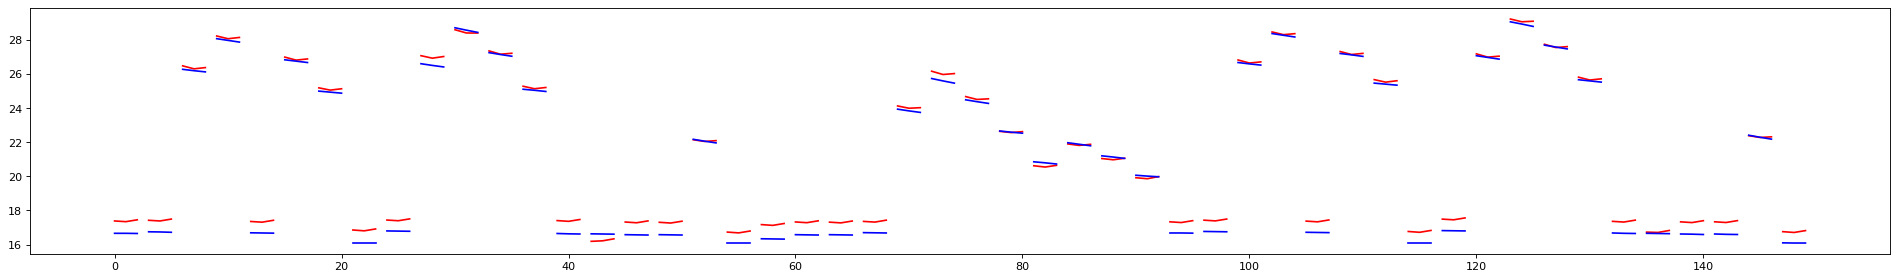

In [19]:
from matplotlib.pyplot import figure

figure(figsize=(30, 4), dpi=80)
for i in range(50):
    new_i = i * 3  # 调整步长为 3，以匹配 y 数据的长度
    plt.plot(range(0 + new_i, 3 + new_i), sample_output[i].detach().cpu().numpy(), color='red')
    plt.plot(range(0 + new_i, 3 + new_i), sample_labels[i].cpu().numpy(), color='blue')
plt.show()